# Classification with reduced training data

In [1]:
# import libraries
import os
import csv
import time
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import accuracy_score

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

from noisecut.model.noisecut_model import NoiseCut
from noisecut.model.noisecut_coder import Metric
from noisecut.tree_structured.data_manipulator import DataManipulator
from noisecut.tree_structured.sample_generator import SampleGenerator


# File path initialization
input_file_path = "../data/"  # Update this to your actual path
# List of dataset names
dataset_names = ["8D_E1" , "8D_E2" , "8D_E3" , "8D_E4" , "8D_E5" , "8D_E6"  ,
                 "9D_E1" , "9D_E2" , "9D_E3" , "9D_E4" , "9D_E5" , "9D_E6"  ,
                 "10D_E1", "10D_E2", "10D_E3", "10D_E4", "10D_E5", "10D_E6" ,
                 "11D_E1", "11D_E2", "11D_E3", "11D_E4", "11D_E5", "11D_E6" ,
                 "12D_E1", "12D_E2", "12D_E3", "12D_E4", "12D_E5", "12D_E6"]

## NoiseCut 

In [2]:
# Set training size and noise intensity
Training_set_size = 30
Noise_intensity = 5

# a dictionary for storing the results
results_NC = {}

# Lists to store FPR and TPR values for each dataset
all_fprs_NC = []
all_tprs_NC = []

max_length = 100  # Choose a suitable maximum length for interpolation

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]

    # For loop for the number of repeating the experiment
    for j in range(5):
        # Add noise in data labeling. Then, train and test set split. 
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=Noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )

        # Read the structure of the data
        with open(file_path, newline="") as csvfile:
            reader = csv.reader(csvfile, delimiter=" ")
            first_row = next(reader)  # Read the first row
        # Convert the string values to integers and store in an array
        data_structure = [int(value) for value in first_row if value.strip() != ""]

        # Fitting the hybrid model
        mdl = NoiseCut(
            n_input_each_box=data_structure
        )  # 'n_input_each_box' should fit to the generated data
        mdl.fit(x_train, y_train)

        # AUC-ROC
        y_pred_proba = mdl.predict_probability_of_being_1(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.astype(int), y_pred_proba)

        # Interpolate or resample FPR and TPR to have the same length
        fpr_interp = np.interp(np.linspace(0, 1, max_length), fpr, fpr)
        tpr_interp = np.interp(np.linspace(0, 1, max_length), fpr, tpr)

        # Store the values in the dictionary
        results_NC[f"dataset_{i}"] = {
            "fpr": fpr_interp,
            "tpr": tpr_interp,
            "thresholds": thresholds,
        }

        # Append FPR and TPR values to the lists
        all_fprs_NC.append(fpr_interp)
        all_tprs_NC.append(tpr_interp)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

# Calculate average FPR and TPR across all datasets
avg_fpr_NC = np.mean(all_fprs_NC, axis=0)
avg_tpr_NC = np.mean(all_tprs_NC, axis=0)


# Sort the lists based on false positive rates for overall AUC-ROC
sorted_indices_NC = sorted(range(len(avg_fpr_NC)), key=lambda k: avg_fpr_NC[k])
avg_fpr_NC_sorted = [avg_fpr_NC[i] for i in sorted_indices_NC]
avg_tpr_NC_sorted = [avg_tpr_NC[i] for i in sorted_indices_NC]

# Calculate overall AUC-ROC
overall_auc_roc_NC = metrics.auc(avg_fpr_NC_sorted, avg_tpr_NC_sorted)
print("Overall AUC-ROC (NoiseCut)=", overall_auc_roc_NC)

Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6
Runtime(seconds)= 50.06166934967041
Overall AUC-ROC (NoiseCut)= 0.9107549929975035


## XGBoost

In [3]:
#####################
### XGBoost Model ###
#####################
def set_best_params_xgb(x_train, y_train, x_test, y_test): 
    tuned_parameters = [
        {
            "learning_rate": [0.01, 0.1],
            "gamma": [0.4, 0.8],
            "max_depth": [6, 8],
            "n_estimators": [200, 400],
            "early_stopping_rounds": [10, 20],
        }
    ]

    # Tuning hyperparameters for classification accuracy
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)

    return grid_search.best_params_

def xgb_model(x_train, y_train, x_test, y_test, best_param):
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        learning_rate=best_param["learning_rate"],
        gamma=best_param["gamma"],
        max_depth=best_param["max_depth"],
        n_estimators=best_param["n_estimators"],
        early_stopping_rounds=best_param["early_stopping_rounds"],
    )

    # Fitting the model with early stopping after 10 epochs to avoid overfitting
    clf = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)
    
    # Return the predicted probabilities and labels
    return clf.predict_proba(x_test), clf.predict(x_test)


##############################
### XGBoost Implementation ###
##############################
# Set training size and noise intensity
Training_set_size = 30
Noise_intensity = 5

# a dictionary for storing the results
results_XGB = {}

# Lists to store TPR and FPR values for each dataset
all_tprs_xgb = []
all_fprs_xgb = []

# Choose a suitable maximum length for interpolation
max_length_xgb = 100

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]
    
    # Parameter tuning for each data set
    manipulator = DataManipulator()
    x_noisy, y_noisy = manipulator.get_noisy_data(
        X, Y, percentage_noise=Noise_intensity
    )
    x_train, y_train, x_test, y_test = manipulator.split_data(
        x_noisy, y_noisy, percentage_training_data=Training_set_size
    )

    best_params_xgb = set_best_params_xgb(x_train, y_train, x_test, y_test)
    #print(best_params_xgb)
    
    # For loop for the number of repeating the experiment
    for j in range(5):
        # Add noise in data labeling. Then, train and test set split. 
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=Noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )

        # Fitting the XGBoost model
        y_pred_proba, y_pred = xgb_model(
            x_train, y_train, x_test, y_test, best_params_xgb
        )

        # AUC-ROC
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])


        # Store the values in the dictionary
        results_XGB[f"dataset_{i}"] = {
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds,
        }

        # Interpolate or resample TPR and FPR to have the same length
        tpr_interp_xgb = np.interp(np.linspace(0, 1, max_length_xgb), fpr, tpr)
        fpr_interp_xgb = np.interp(np.linspace(0, 1, max_length_xgb), fpr, fpr)

        # Append TPR and FPR values to the lists
        all_tprs_xgb.append(tpr_interp_xgb)
        all_fprs_xgb.append(fpr_interp_xgb)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

# Calculate average TPR and FPR across all datasets
avg_tpr_xgb = np.mean(all_tprs_xgb, axis=0)
avg_fpr_xgb = np.mean(all_fprs_xgb, axis=0)


# Sort the lists based on false positive rates for overall AUC-ROC
sorted_indices_xgb = sorted(range(len(avg_fpr_xgb)), key=lambda k: avg_fpr_xgb[k])
avg_fpr_xgb_sorted = [avg_fpr_xgb[i] for i in sorted_indices_xgb]
avg_tpr_xgb_sorted = [avg_tpr_xgb[i] for i in sorted_indices_xgb]

# Calculate overall AUC-ROC
overall_auc_roc_xgb = metrics.auc(avg_fpr_xgb_sorted, avg_tpr_xgb_sorted)
print("Overall AUC-ROC (XGBoost)=", overall_auc_roc_xgb)

Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6
Runtime(seconds)= 550.8305244445801
Overall AUC-ROC (XGBoost)= 0.8221711490267819


## SVM

In [4]:
#################
### SVM Model ###
#################
# Define the SVM parameter tuning function and the model
def set_best_params_svm(x_train, y_train, x_val, y_val):
    tuned_parameters = [
        {
            "C": [10, 100],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
        }
    ]

    # Tuning hyperparameters for classification accuracy
    grid_search = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_


def svm_model_with_early_stopping(x_train, y_train, x_val, y_val, max_no_improvement=5):
    clf = SVC(
        C=best_params_svm["C"],
        kernel=best_params_svm["kernel"],
        gamma=best_params_svm["gamma"],
        probability=True,
    )

    best_accuracy = 0
    no_improvement_count = 0

    # Fitting the model with early stopping
    for epoch in range(max_no_improvement):
        clf.fit(x_train, y_train)

        # Evaluate on the validation set
        val_pred = clf.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= max_no_improvement:
            print(f"Early stopping after {epoch+1} epochs without improvement.")
            break

    # Return the trained model
    return clf

##########################
### SVM Implementation ###
##########################
# Set training size and noise intensity
Training_set_size = 30
Noise_intensity = 5

# a dictionary for storing the results
results_SVM = {}

# Lists to store TPR and FPR values for each dataset
all_tprs_svm = []
all_fprs_svm = []

# Choose a suitable maximum length for interpolation
max_length_svm = 100

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]
    
    # Parameter tuning for each dataset
    manipulator = DataManipulator()
    x_noisy, y_noisy = manipulator.get_noisy_data(
        X, Y, percentage_noise=Noise_intensity
    )
    x_train, y_train, x_val, y_val = manipulator.split_data(
        x_noisy, y_noisy, percentage_training_data=Training_set_size
    )

    # Selecting the best hyperparameters
    best_params_svm = set_best_params_svm(x_train, y_train, x_val, y_val)
    #print(best_params_svm)
    
    # For loop for the number of repeating the experiment
    for j in range(5):
        # Add noise in data labeling. Then, train and test set split. 
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=Noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )
        
        # Fitting the SVM model with early stopping
        clf = svm_model_with_early_stopping(x_train, y_train, x_val, y_val)


        # make predictions for test data
        y_pred_proba = clf.predict_proba(x_val)
        y_pred = clf.predict(x_val)


        # AUC-ROC
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])


        # Store the values in the dictionary
        results_SVM[f"dataset_{i}"] = {
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds,
        }

        # Interpolate or resample TPR and FPR to have the same length
        tpr_interp_svm = np.interp(np.linspace(0, 1, max_length_svm), fpr, tpr)
        fpr_interp_svm = np.interp(np.linspace(0, 1, max_length_svm), fpr, fpr)

        # Append TPR and FPR values to the lists
        all_tprs_svm.append(tpr_interp_svm)
        all_fprs_svm.append(fpr_interp_svm)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

# Calculate average TPR and FPR across all datasets
avg_tpr_svm = np.mean(all_tprs_svm, axis=0)
avg_fpr_svm = np.mean(all_fprs_svm, axis=0)


# Sort the lists based on false positive rates for overall AUC-ROC
sorted_indices_svm = sorted(range(len(avg_fpr_svm)), key=lambda k: avg_fpr_svm[k])
avg_fpr_svm_sorted = [avg_fpr_svm[i] for i in sorted_indices_svm]
avg_tpr_svm_sorted = [avg_tpr_svm[i] for i in sorted_indices_svm]

# Calculate overall AUC-ROC
overall_auc_roc_svm = metrics.auc(avg_fpr_svm_sorted, avg_tpr_svm_sorted)
print("Overall AUC-ROC (SVM)=", overall_auc_roc_svm)

Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6
Runtime(seconds)= 493.1864011287689
Overall AUC-ROC (SVM)= 0.6073220983441359


## Random Forest

In [5]:
###########################
### Random Forest Model ###
###########################
# Define the RandomForest parameter tuning function and the model
def set_best_params_random_forest(x_train, y_train, x_val, y_val):
    tuned_parameters = [
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
        }
    ]

    # Tuning hyperparameters for classification accuracy
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(oob_score=True),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_


def random_forest_model_with_early_stopping(x_train, y_train, x_val, y_val, max_no_improvement=5):
    clf = RandomForestClassifier(
        n_estimators=best_params_rf["n_estimators"],
        max_depth=best_params_rf["max_depth"],
        min_samples_split=best_params_rf["min_samples_split"],
        min_samples_leaf=best_params_rf["min_samples_leaf"],
        oob_score=True,
    )

    best_accuracy = 0
    no_improvement_count = 0

    # Fitting the model with early stopping
    for epoch in range(max_no_improvement):
        clf.fit(x_train, y_train)

        # Evaluate on the validation set
        val_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_val, val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= max_no_improvement:
            print(f"Early stopping after {epoch+1} epochs without improvement.")
            break

    # Return the trained model
    return clf

####################################
### Random Forest Implementation ###
####################################
# Set training size and noise intensity
Training_set_size = 30
Noise_intensity = 5

# a dictionary for storing the results
results_RF = {}

# Lists to store TPR and FPR values for each dataset
all_tprs_rf = []
all_fprs_rf = []

# Choose a suitable maximum length for interpolation
max_length_rf = 100

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]
    
    # Parameter tuning for each dataset
    manipulator = DataManipulator()
    x_noisy, y_noisy = manipulator.get_noisy_data(
        X, Y, percentage_noise=Noise_intensity
    )
    x_train, y_train, x_val, y_val = manipulator.split_data(
        x_noisy, y_noisy, percentage_training_data=Training_set_size
    )

    # Selecting the best hyperparameters
    best_params_rf = set_best_params_random_forest(x_train, y_train, x_val, y_val)
    #print(best_params_rf)
    
    # For loop for the number of repeating the experiment
    for j in range(5):
        # Add noise in data labeling. Then, train and test set split. 
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=Noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )
        
        
        # Fitting the RandomForest model with early stopping
        clf = random_forest_model_with_early_stopping(x_train, y_train, x_val, y_val)

        # make predictions for test data
        y_pred_proba = clf.predict_proba(x_val)
        y_pred = clf.predict(x_val)

        # Evaluation metrics
        accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
            y_val, y_pred
        )
        fpr, tpr, thresholds = metrics.roc_curve(
            y_val.astype(int), y_pred_proba[::, 1]
        )

        # AUC-ROC
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])


        # Store the values in the dictionary
        results_RF[f"dataset_{i}"] = {
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds,
        }

        # Interpolate or resample TPR and FPR to have the same length
        tpr_interp_rf = np.interp(np.linspace(0, 1, max_length_rf), fpr, tpr)
        fpr_interp_rf = np.interp(np.linspace(0, 1, max_length_rf), fpr, fpr)

        # Append TPR and FPR values to the lists
        all_tprs_rf.append(tpr_interp_rf)
        all_fprs_rf.append(fpr_interp_rf)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

# Calculate average TPR and FPR across all datasets
avg_tpr_rf = np.mean(all_tprs_rf, axis=0)
avg_fpr_rf = np.mean(all_fprs_rf, axis=0)


# Sort the lists based on false positive rates for overall AUC-ROC
sorted_indices_rf = sorted(range(len(avg_fpr_rf)), key=lambda k: avg_fpr_rf[k])
avg_fpr_rf_sorted = [avg_fpr_rf[i] for i in sorted_indices_rf]
avg_tpr_rf_sorted = [avg_tpr_rf[i] for i in sorted_indices_rf]

# Calculate overall AUC-ROC
overall_auc_roc_rf = metrics.auc(avg_fpr_rf_sorted, avg_tpr_rf_sorted)
print("Overall AUC-ROC (Random Forest)=", overall_auc_roc_rf)

Dataset: 8D_E1
Dataset: 8D_E2
Dataset: 8D_E3
Dataset: 8D_E4
Dataset: 8D_E5
Dataset: 8D_E6
Dataset: 9D_E1
Dataset: 9D_E2
Dataset: 9D_E3
Dataset: 9D_E4
Dataset: 9D_E5
Dataset: 9D_E6
Dataset: 10D_E1
Dataset: 10D_E2
Dataset: 10D_E3
Dataset: 10D_E4
Dataset: 10D_E5
Dataset: 10D_E6
Dataset: 11D_E1
Dataset: 11D_E2
Dataset: 11D_E3
Dataset: 11D_E4
Dataset: 11D_E5
Dataset: 11D_E6
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Dataset: 12D_E6
Runtime(seconds)= 645.1964688301086
Overall AUC-ROC (Random Forest)= 0.6020575977444443


## Deep Neural Network

In [6]:
###############################################################################################
# Note:                                                                                       #
# The calculations of deep neural network model are not included in this notebook to avoid    #
# complications of Tensorflow and its dependencies installation.                              #
# The codes are provided below just for illustration.                                         #
###############################################################################################
# # import Tensorflow related libraries
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split


# # Define the Neural Network function with variable hidden layer sizes
# def create_neural_network(hidden_layer_sizes=[64]):
#     model = Sequential()
#     for size in hidden_layer_sizes:
#         model.add(Dense(size, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# # Neural Network implementation with hyperparameter tuning using GridSearchCV
# # a dictionary for storing the results
# results_NeuralNetwork = {}

# # Set training size and noise intensity
# Training_set_size = 30
# Noise_intensity = 5

# # a dictionary for storing the results
# results_NN = {}

# # Lists to store TPR and FPR values for each dataset
# all_tprs_nn = []
# all_fprs_nn = []

# # Choose a suitable maximum length for interpolation
# max_length_nn = 100

# # Loop through each file
# i = 0  # loop counter
# st = time.time()  # start timer
# for dataset_name in dataset_names:
#     print(f"Dataset: {dataset_name}")
#     i += 1
#     file_path = os.path.join(input_file_path, dataset_name)

#     # Read the CSV file
#     data = pd.read_csv(
#         file_path, delimiter="    ", header=None, skiprows=1, engine="python"
#     )
#     # Split the data into X and Y
#     X = data.iloc[:, :-1]
#     Y = data.iloc[:, -1]
    
#     # Parameter tuning for each dataset
#     manipulator = DataManipulator()
#     x_noisy, y_noisy = manipulator.get_noisy_data(
#         X, Y, percentage_noise=Noise_intensity
#     )
    
#     x_train, x_val, y_train, y_val = train_test_split(
#         x_noisy, y_noisy, test_size=0.7, random_state=42
#     )

#     # Define the parameter grid for hyperparameter tuning
#     param_grid = {
#         'hidden_layer_sizes': [(128,), (256,), (512,), 
#                                (256, 128), (512, 256), 
#                                (256, 128, 64), (512, 256, 128)],
#         'epochs': [50, 100, 200],
#     }

#     # Build and train the Neural Network with hyperparameter tuning
#     model = KerasClassifier(build_fn=create_neural_network, verbose=0)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='accuracy',
#         cv=StratifiedKFold(n_splits=5, shuffle=True),
#         verbose=0
#     )
#     grid_result = grid_search.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

#     # Get the best parameters from the grid search
#     best_params = grid_result.best_params_
    
    
#     # For loop for the number of repeating the experiment
#     for j in range(5):
#         # Add noise in data labeling. Then, train and test set split. 
#         manipulator = DataManipulator()
#         x_noisy, y_noisy = manipulator.get_noisy_data(
#             X, Y, percentage_noise=Noise_intensity
#         )
#         x_train, x_val, y_train, y_val = train_test_split(
#             x_noisy, y_noisy, test_size=0.7, random_state=42
#         )
        
#         # Build the final model with the best parameters
#         final_model = create_neural_network(hidden_layer_sizes=best_params['hidden_layer_sizes'])
#         final_model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping])

#         # make predictions for validation data
#         y_pred_proba = final_model.predict(x_val)
#         y_pred = (y_pred_proba > 0.5).astype(int)

#         # Evaluation metrics
#         accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
#             y_val, y_pred
#         )
#         fpr, tpr, thresholds = metrics.roc_curve(
#             y_val.astype(int), y_pred_proba
#         )


#         # Store the values in the dictionary
#         results_NN[f"dataset_{i}"] = {
#             "fpr": fpr,
#             "tpr": tpr,
#             "thresholds": thresholds,
#         }

#         # Interpolate or resample TPR and FPR to have the same length
#         tpr_interp_nn = np.interp(np.linspace(0, 1, max_length_nn), fpr, tpr)
#         fpr_interp_nn = np.interp(np.linspace(0, 1, max_length_nn), fpr, fpr)

#         # Append TPR and FPR values to the lists
#         all_tprs_nn.append(tpr_interp_nn)
#         all_fprs_nn.append(fpr_interp_nn)

# run_time = time.time() - st
# print("Runtime(seconds)=", run_time)

# # Calculate average TPR and FPR across all datasets
# avg_tpr_nn = np.mean(all_tprs_nn, axis=0)
# avg_fpr_nn = np.mean(all_fprs_nn, axis=0)


# # Sort the lists based on false positive rates for overall AUC-ROC
# sorted_indices_nn = sorted(range(len(avg_fpr_nn)), key=lambda k: avg_fpr_nn[k])
# avg_fpr_nn_sorted = [avg_fpr_nn[i] for i in sorted_indices_nn]
# avg_tpr_nn_sorted = [avg_tpr_nn[i] for i in sorted_indices_nn]

# # Calculate overall AUC-ROC
# overall_auc_roc_nn = metrics.auc(avg_fpr_nn_sorted, avg_tpr_nn_sorted)
# print("Overall AUC-ROC (Random Forest)=", overall_auc_roc_nn)

2024-02-08 16:45:31.414645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset: 8D_E1


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)
2024-02-08 16:45:32.733028: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


6/6 [==============================] - 0s 10ms/step
Dataset: 8D_E2


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


6/6 [==============================] - 0s 6ms/step
Dataset: 8D_E3


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


6/6 [==============================] - 0s 3ms/step
Dataset: 8D_E4


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


6/6 [==============================] - 0s 11ms/step
Dataset: 8D_E5


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


6/6 [==============================] - 0s 6ms/step
Dataset: 8D_E6


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


6/6 [==============================] - 0s 2ms/step
Dataset: 9D_E1


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 2ms/step
Dataset: 9D_E2


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 2ms/step
Dataset: 9D_E3


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 2ms/step
Dataset: 9D_E4


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 5ms/step
Dataset: 9D_E5


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 6ms/step
Dataset: 9D_E6


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


12/12 [==============================] - 0s 1ms/step
Dataset: 10D_E1


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 4ms/step
Dataset: 10D_E2


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 3ms/step
Dataset: 10D_E3


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 2ms/step
Dataset: 10D_E4


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 4ms/step
Dataset: 10D_E5


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 3ms/step
Dataset: 10D_E6


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


23/23 [==============================] - 0s 4ms/step
Dataset: 11D_E1


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 3ms/step
Dataset: 11D_E2


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 2ms/step
Dataset: 11D_E3


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 6ms/step
Dataset: 11D_E4


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 3ms/step
Dataset: 11D_E5


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 4ms/step
Dataset: 11D_E6


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


45/45 [==============================] - 0s 2ms/step
Dataset: 12D_E1


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 2ms/step
Dataset: 12D_E2


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 2ms/step
Dataset: 12D_E3


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 2ms/step
Dataset: 12D_E4


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 2ms/step
Dataset: 12D_E5


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 1ms/step
Dataset: 12D_E6


/tmp/ipykernel_9307/2486336337.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_neural_network, verbose=0)


90/90 [==============================] - 0s 2ms/step
Runtime(seconds)= 1180.890480041504
Overall AUC-ROC (Random Forest)= 0.7892759939962393


## Plots

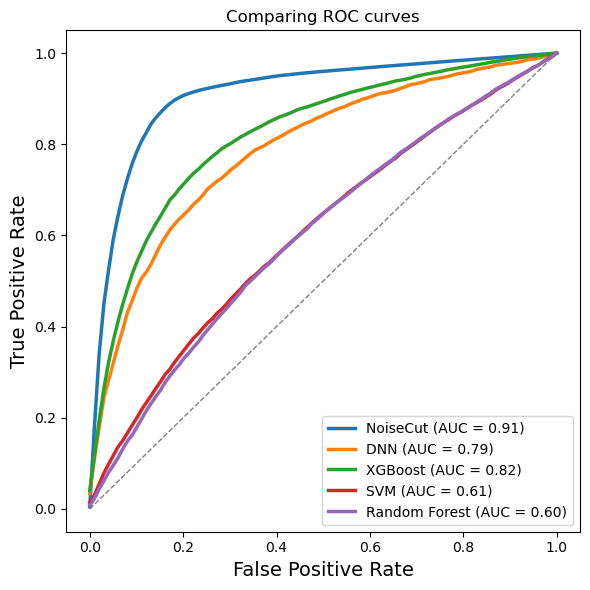

In [11]:
# Set up the figure
fig, ax = plt.subplots(figsize=(6, 6))


ax.title.set_fontsize(16)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)


# Plot ROC curves
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

############
# NoiseCut #
############
ax.plot(
    avg_fpr_NC,
    avg_tpr_NC,
    "-",
    #color="royalblue",
    label="NoiseCut (AUC = {:.2f})".format(
        metrics.auc(avg_fpr_NC_sorted, avg_tpr_NC_sorted)
    ),
    linewidth=2.5,
)

###########
# DNN #
###########
ax.plot(
    avg_fpr_nn,
    avg_tpr_nn,
    "-",
    #color="peru",
    label="DNN (AUC = {:.2f})".format(
        metrics.auc(avg_fpr_nn_sorted, avg_tpr_nn_sorted)
    ),
    linewidth=2.5,
)

###########
# XGBoost #
###########
ax.plot(
    avg_fpr_xgb,
    avg_tpr_xgb,
    "-",
    #color="peru",
    label="XGBoost (AUC = {:.2f})".format(
        metrics.auc(avg_fpr_xgb_sorted, avg_tpr_xgb_sorted)
    ),
    linewidth=2.5,
)

#######
# SVM #
#######
ax.plot(
    avg_fpr_svm,
    avg_tpr_svm,
    "-",
    #color="peru",
    label="SVM (AUC = {:.2f})".format(
        metrics.auc(avg_fpr_svm_sorted, avg_tpr_svm_sorted)
    ),
    linewidth=2.5,
)

#################
# Random Forest #
#################
ax.plot(
    avg_fpr_rf,
    avg_tpr_rf,
    "-",
    #color="peru",
    label="Random Forest (AUC = {:.2f})".format(
        metrics.auc(avg_fpr_rf_sorted, avg_tpr_rf_sorted)
    ),
    linewidth=2.5,
)


# Set title, labels, and legend
ax.set_title("Comparing ROC curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
#ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("./multiple_roc_curve_plain.png", dpi=300)